# Demo

This notebook is provided to describe the usage of pydpac using a one-dimensional toy model known as [the Lorenz (1996) model](https://doi.org/10.1175/1520-0469(1998)055%3C0399:OSFSWO%3E2.0.CO;2) described by the following equation.
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$

## Available DA algorithms

A data assimilation (DA) algorithm can be chosen from the followings.

- Kalman Filter ([Kalman 1960](https://doi.org/10.1115/1.3662552))
- 3DVar, 4DVar ([Talagrand and Courtier 1987](https://doi.org/10.1002/qj.49711347812))
- Ensemble Kalman Filter([Evensen 1994](https://doi.org/10.1029/94JC00572))
 * ETKF ([Bishop et al. 2001](https://doi.org/10.1175/1520-0493(2001)129%3C0420:ASWTET%3E2.0.CO;2))
 * PO ([Burgers et al. 1998](https://doi.org/10.1175/1520-0493(1998)126%3C1719:ASITEK%3E2.0.CO;2), [Houtekamer et al.2005](https://doi.org/10.1175/MWR-2864.1))
 * EnSRF ([Whitaker and Hamill 2002](https://doi.org/10.1175/1520-0493(2002)130%3C1913:EDAWPO%3E2.0.CO;2))
 * LETKF ([Hunt et al. 2007](https://doi.org/10.1016/j.physd.2006.11.008))
- Maximum Likelihoon Ensemble Filter ([Zupanski 2005](https://doi.org/10.1175/MWR2946.1), [Zupanski et al. 2008](https://doi.org/10.1002/qj.251))

## Requirements

- numpy for the model and DA
- pandas for error statistics
- matplotlib for plots

## Usage

Execute the cells below sequentially.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

In [2]:
# model parameter
#model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)

# forecast model forward operator
step = L96(nx, dt, F)

In [3]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [4]:
# DA experiment parameters (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
infl_parm = 1.1 # multiplicative inflation parameter
lloc = True # localization switch (True=Apply, False=Not apply)
lsig = 4.0 # localization radius
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [5]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# specify assimilation method
from analysis.mlef import Mlef
#analysis = Mlef(pt, obs, infl_parm, lsig, linf, lloc, ltlm, model)
analysis = Mlef(pt, obs, infl_parm, lsig, linf, lloc, ltlm)
#from analysis.enkf import EnKF
#analysis = EnKF(pt, obs, infl_parm, lsig, linf, lloc, ltlm, model)
#from analysis.kf import Kf
#analysis = Kf(pt, obs, infl_parm, linf, step)
#from analysis.var import Var
#analysis = Var(pt, obs, model)
#from analysis.var4d import Var4d
#analysis = Var4d(pt, obs, model, step, nt, a_window)

2021-01-18 08:27:37,749 anl INFO model : model
2021-01-18 08:27:37,750 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.1 lsig=4.0
2021-01-18 08:27:37,750 anl INFO linf=True lloc=True ltlm=True


In [6]:
# load functions
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, \
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm}
func = L96_func(params)

In [8]:
# get truth and make observation
xt, yobs = func.get_true_and_obs()
# initialize all variables
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
 
# analysis-forecast cycle timelot 
# (if analysis is 4-dimensional, analysis is taken every a_window steps.)
a_time = range(0, na, a_window)
e = np.zeros(na) # RMSE between Truth and Analysis
chi = np.zeros(na) # Chi2 test (values are nearly equal to 1 is good)
dof = np.zeros(na) # DOF for signal
for i in a_time:
    # read observation
    y = yobs[i:i+a_window]
    # analysis
    if a_window > 1: # assimilate observations at different time (4-dimensional)
        u, pa, ds = analysis(u, pf, y, cycle=i)
    else: # assimilate observations at a time
        u, pa, innv, chi2, ds = analysis(u, pf, y[0], icycle=i)

    xa[i] = u # analysis
    sqrtpa[i] = pa # (mlef) analysis error covariance square root matrix
                   # (other) analysis error covariance matrix
    chi[i] = chi2
    dof[i] = ds
    if i < na-1:
        # forecast
        if a_window > 1: # 4-dimensional
            uf, p = func.forecast(u, pa)
            if (i+1+a_window <= na):
                xa[i+1:i+1+a_window] = uf
                xf[i+1:i+1+a_window] = uf
                sqrtpa[i+1:i+1+a_window, :, :] = p[:, :]
            else:
                xa[i+1:na] = uf[:na-i-1]
                xf[i+1:na] = uf[:na-i-1]
                sqrtpa[i+1:na, :, :] = p[:na-i-1, :, :]
            u = uf[-1]
            pf = p[-1]
        else:
            u, pf = func.forecast(u, pa, tlm=ltlm)
            xf[i+1] = u
    # calcurate RMSE and save
    if a_window > 1: # 4-dimensional
        if ft == "deterministic":
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
        else:
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :, 0] - xt[k, :])**2))
    else:
        if ft == "deterministic":
            e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
        else:
            e[i] = np.sqrt(np.mean((xa[i, :, 0] - xt[i, :])**2))
    

2021-01-18 08:29:26,192 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:26,193 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:26,196 anl INFO save_dh=False
2021-01-18 08:29:26,204 anl INFO singular value =[70.84114631 57.10783606 51.88216762 46.55820687 37.63676881 31.40152629
 28.9107826  27.64997234 27.2254882  26.31530313 24.22211632 23.390941
 22.74363069 22.30512049 21.12090417 20.11722236 19.70388942 18.54134353
 18.27294769 18.01307435]
2021-01-18 08:29:26,205 anl INFO save_hist=False
2021-01-18 08:29:26,303 anl INFO success=False message=Desired error not necessarily achieved due to precision loss.
2021-01-18 08:29:26,304 anl INFO J=7.732e+01 dJ=2.691e-05 nit=91
2021-01-18 08:29:26,310 anl INFO singular value =[70.84114631 57.10783606 51.88216762 46.55820687 37.63676881 31.40152629
 28.9107826  27.64997234 27.2254882  26.31530313 24.22211632 23.390941
 22.74363069 22.30512049 21.12090417 20.11722236 19.70388942 18.54134353
 18.27294769 18.01307435]
2021-01-18 08:29:26,

2021-01-18 08:29:26,471 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:26,472 anl INFO d shape=(40,)
2021-01-18 08:29:26,473 anl INFO converge gmat, iter_num=2, norm=1.465780736653949e-06
2021-01-18 08:29:26,475 anl INFO err=[[ 1.62563132e-08  1.15620328e-08 -2.00264940e-08 ... -3.23258808e-09
   1.38644461e-08  6.15391944e-09]
 [ 1.15620328e-08  1.40624647e-08 -2.28253754e-08 ... -9.05844801e-10
   8.02206561e-09  4.11940272e-09]
 [-2.00264940e-08 -2.28253754e-08  3.73382230e-08 ...  2.22281064e-09
  -1.38597821e-08 -7.43659871e-09]
 ...
 [-3.23258807e-09 -9.05844798e-10  2.22281063e-09 ...  1.22443824e-08
   2.08817963e-09 -4.92570289e-09]
 [ 1.38644461e-08  8.02206562e-09 -1.38597822e-08 ...  2.08817963e-09
   2.78796807e-08 -8.39541246e-10]
 [ 6.15391946e-09  4.11940272e-09 -7.43659871e-09 ... -4.92570290e-09
  -8.39541263e-10  5.05352271e-09]]
2021-01-18 08:29:26,475 anl INFO dof=5.982646218847701
2021-01-18 08:29:26,481 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:26,482 anl

2021-01-18 08:29:26,649 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:26,649 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:26,652 anl INFO save_dh=False
2021-01-18 08:29:26,660 anl INFO singular value =[0.90201443 0.8335922  0.79323554 0.76839936 0.74678697 0.68096682
 0.65133266 0.53977371 0.51684305 0.50895475 0.50004932 0.47721943
 0.42816325 0.40807402 0.4018688  0.40052342 0.34109136 0.3393079
 0.3366539  0.30738743]
2021-01-18 08:29:26,661 anl INFO save_hist=False
2021-01-18 08:29:26,666 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:26,667 anl INFO J=7.702e+01 dJ=9.833e-07 nit=7
2021-01-18 08:29:26,674 anl INFO singular value =[0.90201443 0.8335922  0.79323554 0.76839936 0.74678697 0.68096682
 0.65133266 0.53977371 0.51684305 0.50895475 0.50004932 0.47721943
 0.42816325 0.40807402 0.4018688  0.40052342 0.34109136 0.3393079
 0.3366539  0.30738743]
2021-01-18 08:29:26,675 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:26,675 anl INF

2021-01-18 08:29:26,820 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:26,821 anl INFO d shape=(40,)
2021-01-18 08:29:26,822 anl INFO converge gmat, iter_num=2, norm=6.908045911847212e-07
2021-01-18 08:29:26,824 anl INFO err=[[ 3.40332651e-10 -3.52214317e-10  3.40743231e-10 ... -3.01379647e-10
  -1.05837825e-09 -5.11182073e-11]
 [-3.52214313e-10  1.62353619e-09 -1.33550086e-09 ...  1.70814864e-10
   4.37776401e-10 -7.65347560e-11]
 [ 3.40743232e-10 -1.33550086e-09  1.51298440e-09 ... -1.09617718e-10
  -2.68114307e-10  7.93638471e-11]
 ...
 [-3.01379645e-10  1.70814861e-10 -1.09617715e-10 ...  3.01839886e-10
   1.06010552e-09  6.49393980e-11]
 [-1.05837826e-09  4.37776396e-10 -2.68114305e-10 ...  1.06010552e-09
   3.85201959e-09  2.49630256e-10]
 [-5.11182060e-11 -7.65347542e-11  7.93638471e-11 ...  6.49393976e-11
   2.49630256e-10  2.34363640e-11]]
2021-01-18 08:29:26,825 anl INFO dof=4.350087530684037
2021-01-18 08:29:26,831 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:26,831 anl

2021-01-18 08:29:26,978 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:26,979 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:26,983 anl INFO save_dh=False
2021-01-18 08:29:26,992 anl INFO singular value =[0.86738745 0.85747657 0.78965284 0.78503493 0.75435745 0.72622181
 0.68400715 0.60841666 0.5768502  0.52937307 0.50822081 0.49790301
 0.46926813 0.39971052 0.39824815 0.37512999 0.34217837 0.27899475
 0.2428935  0.2269533 ]
2021-01-18 08:29:26,993 anl INFO save_hist=False
2021-01-18 08:29:26,998 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:26,998 anl INFO J=2.978e+01 dJ=7.893e-07 nit=7
2021-01-18 08:29:27,007 anl INFO singular value =[0.86738745 0.85747657 0.78965284 0.78503493 0.75435745 0.72622181
 0.68400715 0.60841666 0.5768502  0.52937307 0.50822081 0.49790301
 0.46926813 0.39971052 0.39824815 0.37512999 0.34217837 0.27899475
 0.2428935  0.2269533 ]
2021-01-18 08:29:27,007 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:27,008 anl I

2021-01-18 08:29:27,159 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:27,159 anl INFO d shape=(40,)
2021-01-18 08:29:27,161 anl INFO converge gmat, iter_num=2, norm=8.85327832105121e-07
2021-01-18 08:29:27,162 anl INFO err=[[ 1.08132929e-07  4.08106344e-08  5.72844391e-08 ... -2.90652473e-08
  -7.11118960e-08 -1.74489188e-08]
 [ 4.08106344e-08  1.56553388e-08  2.19554485e-08 ... -1.04791556e-08
  -2.58840285e-08 -6.55126743e-09]
 [ 5.72844391e-08  2.19554486e-08  3.07939306e-08 ... -1.47425621e-08
  -3.63984732e-08 -9.19866811e-09]
 ...
 [-2.90652473e-08 -1.04791556e-08 -1.47425620e-08 ...  8.80611328e-09
   2.10430379e-08  4.75219285e-09]
 [-7.11118960e-08 -2.58840284e-08 -3.63984731e-08 ...  2.10430379e-08
   5.05109783e-08  1.15962737e-08]
 [-1.74489188e-08 -6.55126743e-09 -9.19866810e-09 ...  4.75219285e-09
   1.15962737e-08  2.82071400e-09]]
2021-01-18 08:29:27,163 anl INFO dof=4.7934254170877955
2021-01-18 08:29:27,170 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:27,171 anl

2021-01-18 08:29:27,314 anl INFO dof=4.870024640922419
2021-01-18 08:29:27,318 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:27,319 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:27,322 anl INFO save_dh=False
2021-01-18 08:29:27,330 anl INFO singular value =[1.00871918 0.92345686 0.87127119 0.86009438 0.75295274 0.67396235
 0.64257141 0.61640825 0.57499396 0.5392406  0.51814037 0.51501927
 0.448699   0.4323555  0.42578634 0.40299326 0.37623656 0.32391068
 0.26049766 0.2438499 ]
2021-01-18 08:29:27,331 anl INFO save_hist=False
2021-01-18 08:29:27,337 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:27,337 anl INFO J=2.893e+01 dJ=9.824e-08 nit=8
2021-01-18 08:29:27,346 anl INFO singular value =[1.00871918 0.92345686 0.87127119 0.86009438 0.75295274 0.67396235
 0.64257141 0.61640825 0.57499396 0.5392406  0.51814037 0.51501927
 0.448699   0.4323555  0.42578634 0.40299326 0.37623656 0.32391068
 0.26049766 0.2438499 ]
2021-01-18 08:29:27,347 anl

2021-01-18 08:29:27,499 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:27,499 anl INFO d shape=(40,)
2021-01-18 08:29:27,500 anl INFO converge gmat, iter_num=2, norm=1.6110729964262045e-06
2021-01-18 08:29:27,502 anl INFO err=[[ 7.74178444e-09  1.00770686e-08  1.96632752e-08 ... -3.68455715e-10
   3.86888611e-12  1.83935939e-09]
 [ 1.00770686e-08  1.32416251e-08  2.60101492e-08 ...  3.75036113e-11
   6.28807654e-10  2.34247020e-09]
 [ 1.96632752e-08  2.60101492e-08  5.20675343e-08 ...  1.77430443e-10
   1.35092451e-09  4.68223851e-09]
 ...
 [-3.68455714e-10  3.75036113e-11  1.77430442e-10 ...  2.66768119e-09
   3.20248055e-09 -4.35809337e-10]
 [ 3.86888785e-12  6.28807655e-10  1.35092451e-09 ...  3.20248055e-09
   3.87615862e-09 -3.99424081e-10]
 [ 1.83935940e-09  2.34247020e-09  4.68223852e-09 ... -4.35809330e-10
  -3.99424084e-10  5.74610803e-10]]
2021-01-18 08:29:27,503 anl INFO dof=5.0986717868369915
2021-01-18 08:29:27,509 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:27,510 a

2021-01-18 08:29:27,653 anl INFO dof=5.0208099041366925
2021-01-18 08:29:27,660 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:27,660 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:27,664 anl INFO save_dh=False
2021-01-18 08:29:27,672 anl INFO singular value =[1.06925474 0.96998671 0.87833464 0.80259999 0.76169676 0.68129148
 0.64703002 0.57900505 0.56417773 0.53451808 0.48002772 0.46097294
 0.4572175  0.44150899 0.4361658  0.40881003 0.34864634 0.33530508
 0.31343417 0.30240788]
2021-01-18 08:29:27,673 anl INFO save_hist=False
2021-01-18 08:29:27,679 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:27,680 anl INFO J=3.065e+01 dJ=1.360e-06 nit=8
2021-01-18 08:29:27,687 anl INFO singular value =[1.06925474 0.96998671 0.87833464 0.80259999 0.76169676 0.68129148
 0.64703002 0.57900505 0.56417773 0.53451808 0.48002772 0.46097294
 0.4572175  0.44150899 0.4361658  0.40881003 0.34864634 0.33530508
 0.31343417 0.30240788]
2021-01-18 08:29:27,689 an

2021-01-18 08:29:27,842 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:27,843 anl INFO d shape=(40,)
2021-01-18 08:29:27,844 anl INFO converge gmat, iter_num=2, norm=9.44058635736611e-07
2021-01-18 08:29:27,846 anl INFO err=[[ 1.38104439e-09  2.41591559e-09 -8.82211700e-10 ...  2.70280281e-10
  -3.91433344e-10  2.21753151e-10]
 [ 2.41591559e-09  4.35076131e-09 -1.39666280e-09 ...  4.62523235e-10
  -6.83367304e-10  4.02656290e-10]
 [-8.82211693e-10 -1.39666280e-09  1.63501690e-09 ... -1.72810298e-10
   2.67012915e-10 -2.13951075e-10]
 ...
 [ 2.70280281e-10  4.62523233e-10 -1.72810299e-10 ...  5.53784796e-11
  -7.62053129e-11  3.89885485e-11]
 [-3.91433358e-10 -6.83367307e-10  2.67012917e-10 ... -7.62053146e-11
   1.11294307e-10 -6.46523217e-11]
 [ 2.21753147e-10  4.02656290e-10 -2.13951074e-10 ...  3.89885520e-11
  -6.46523221e-11  4.91030550e-11]]
2021-01-18 08:29:27,847 anl INFO dof=4.559675822255311
2021-01-18 08:29:27,854 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:27,854 anl 

2021-01-18 08:29:27,998 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:27,998 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:28,001 anl INFO save_dh=False
2021-01-18 08:29:28,009 anl INFO singular value =[1.04495849 1.04353934 0.77218108 0.71778131 0.70581414 0.65727274
 0.64943604 0.62865056 0.62687579 0.56596499 0.52416323 0.50132247
 0.49695823 0.41524111 0.35128138 0.33123869 0.31116456 0.29594964
 0.27540861 0.26203369]
2021-01-18 08:29:28,009 anl INFO save_hist=False
2021-01-18 08:29:28,014 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:28,014 anl INFO J=2.725e+01 dJ=2.376e-06 nit=6
2021-01-18 08:29:28,022 anl INFO singular value =[1.04495849 1.04353934 0.77218108 0.71778131 0.70581414 0.65727274
 0.64943604 0.62865056 0.62687579 0.56596499 0.52416323 0.50132247
 0.49695823 0.41524111 0.35128138 0.33123869 0.31116456 0.29594964
 0.27540861 0.26203369]
2021-01-18 08:29:28,023 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:28,023 anl I

2021-01-18 08:29:28,165 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:28,166 anl INFO d shape=(40,)
2021-01-18 08:29:28,168 anl INFO converge gmat, iter_num=2, norm=1.0744966031162151e-06
2021-01-18 08:29:28,169 anl INFO err=[[ 1.27961208e-09  3.36339630e-10 -6.84335269e-10 ...  1.26767181e-08
  -4.58915295e-09  3.37400863e-09]
 [ 3.36339635e-10  1.12867715e-10 -3.40642813e-10 ...  3.12668929e-09
  -1.12988161e-09  8.48470441e-10]
 [-6.84335260e-10 -3.40642802e-10  1.43180412e-09 ... -5.42789354e-09
   1.95139760e-09 -1.54820042e-09]
 ...
 [ 1.26767181e-08  3.12668929e-09 -5.42789354e-09 ...  1.27367636e-07
  -4.61210945e-08  3.37576351e-08]
 [-4.58915296e-09 -1.12988161e-09  1.95139760e-09 ... -4.61210945e-08
   1.67016269e-08 -1.22234247e-08]
 [ 3.37400863e-09  8.48470443e-10 -1.54820041e-09 ...  3.37576351e-08
  -1.22234247e-08  8.95998675e-09]]
2021-01-18 08:29:28,170 anl INFO dof=4.415012159234686
2021-01-18 08:29:28,173 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:28,174 an

2021-01-18 08:29:28,320 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:28,321 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:28,324 anl INFO save_dh=False
2021-01-18 08:29:28,333 anl INFO singular value =[1.13350136 0.70302608 0.7006991  0.65457256 0.65100572 0.61910881
 0.60421312 0.58469879 0.55979183 0.54740656 0.4750359  0.41834411
 0.39858521 0.39372173 0.36272374 0.3107178  0.30282222 0.29528816
 0.2757273  0.26122503]
2021-01-18 08:29:28,334 anl INFO save_hist=False
2021-01-18 08:29:28,339 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:28,340 anl INFO J=1.986e+01 dJ=5.164e-07 nit=7
2021-01-18 08:29:28,348 anl INFO singular value =[1.13350136 0.70302608 0.7006991  0.65457256 0.65100572 0.61910881
 0.60421312 0.58469879 0.55979183 0.54740656 0.4750359  0.41834411
 0.39858521 0.39372173 0.36272374 0.3107178  0.30282222 0.29528816
 0.2757273  0.26122503]
2021-01-18 08:29:28,349 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:28,349 anl I

2021-01-18 08:29:28,503 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:28,504 anl INFO d shape=(40,)
2021-01-18 08:29:28,506 anl INFO converge gmat, iter_num=2, norm=6.501818180429312e-07
2021-01-18 08:29:28,508 anl INFO err=[[ 2.08899453e-10 -5.34204556e-10 -4.49704593e-10 ...  1.09503212e-09
  -5.62380194e-11  1.13634760e-10]
 [-5.34204549e-10  1.67452896e-09  1.43387539e-09 ... -1.18760568e-09
   7.55223948e-11 -1.46836941e-10]
 [-4.49704593e-10  1.43387539e-09  1.24968413e-09 ... -8.25232581e-10
   5.88202100e-11 -1.10093292e-10]
 ...
 [ 1.09503212e-09 -1.18760568e-09 -8.25232575e-10 ...  1.43990970e-08
  -6.25776122e-10  1.35931708e-09]
 [-5.62380194e-11  7.55224009e-11  5.88202174e-11 ... -6.25776125e-10
   1.08925868e-10 -4.74644456e-11]
 [ 1.13634763e-10 -1.46836938e-10 -1.10093290e-10 ...  1.35931708e-09
  -4.74644542e-11  1.31926581e-10]]
2021-01-18 08:29:28,508 anl INFO dof=4.459894843907543
2021-01-18 08:29:28,513 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:28,513 anl

2021-01-18 08:29:28,664 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:28,664 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:28,668 anl INFO save_dh=False
2021-01-18 08:29:28,676 anl INFO singular value =[0.96951196 0.87852213 0.85928362 0.79411867 0.69737514 0.56478479
 0.52563495 0.51925594 0.50866275 0.45897383 0.43730665 0.42600232
 0.4100387  0.40616879 0.39448376 0.37838712 0.34655711 0.34405842
 0.29899939 0.25722909]
2021-01-18 08:29:28,677 anl INFO save_hist=False
2021-01-18 08:29:28,682 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:28,683 anl INFO J=1.824e+01 dJ=1.550e-06 nit=7
2021-01-18 08:29:28,691 anl INFO singular value =[0.96951196 0.87852213 0.85928362 0.79411867 0.69737514 0.56478479
 0.52563495 0.51925594 0.50866275 0.45897383 0.43730665 0.42600232
 0.4100387  0.40616879 0.39448376 0.37838712 0.34655711 0.34405842
 0.29899939 0.25722909]
2021-01-18 08:29:28,692 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:28,693 anl I

2021-01-18 08:29:28,836 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:28,837 anl INFO d shape=(40,)
2021-01-18 08:29:28,839 anl INFO converge gmat, iter_num=2, norm=4.2359462348908777e-07
2021-01-18 08:29:28,841 anl INFO err=[[ 2.04130488e-08  1.59311281e-08 -2.31880334e-09 ... -1.46288712e-08
  -5.90739609e-08 -2.02291059e-08]
 [ 1.59311282e-08  1.25817819e-08 -1.82444892e-09 ... -1.13334011e-08
  -4.55978771e-08 -1.56796974e-08]
 [-2.31880334e-09 -1.82444892e-09  2.74772427e-10 ...  1.65198057e-09
   6.64224440e-09  2.28617508e-09]
 ...
 [-1.46288712e-08 -1.13334011e-08  1.65198057e-09 ...  1.05377921e-08
   4.26124047e-08  1.45603190e-08]
 [-5.90739609e-08 -4.55978770e-08  6.64224440e-09 ...  4.26124047e-08
   1.72730338e-07  5.89081531e-08]
 [-2.02291059e-08 -1.56796973e-08  2.28617508e-09 ...  1.45603190e-08
   5.89081531e-08  2.01262375e-08]]
2021-01-18 08:29:28,842 anl INFO dof=4.03245436069564
2021-01-18 08:29:28,845 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:28,846 anl

2021-01-18 08:29:28,993 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:28,993 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:28,997 anl INFO save_dh=False
2021-01-18 08:29:29,006 anl INFO singular value =[0.780903   0.76887246 0.71536721 0.70692687 0.59470235 0.58481662
 0.52982349 0.49072688 0.42995966 0.41865569 0.40414875 0.40327612
 0.38407272 0.36331527 0.35844078 0.33346351 0.32031794 0.31885078
 0.29720562 0.25271103]
2021-01-18 08:29:29,007 anl INFO save_hist=False
2021-01-18 08:29:29,011 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:29,012 anl INFO J=1.425e+01 dJ=1.366e-06 nit=6
2021-01-18 08:29:29,020 anl INFO singular value =[0.780903   0.76887246 0.71536721 0.70692687 0.59470235 0.58481662
 0.52982349 0.49072688 0.42995966 0.41865569 0.40414875 0.40327612
 0.38407272 0.36331527 0.35844078 0.33346351 0.32031794 0.31885078
 0.29720562 0.25271103]
2021-01-18 08:29:29,021 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:29,021 anl I

2021-01-18 08:29:29,176 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:29,177 anl INFO d shape=(40,)
2021-01-18 08:29:29,179 anl INFO converge gmat, iter_num=2, norm=3.3558118906700286e-07
2021-01-18 08:29:29,180 anl INFO err=[[ 1.28857869e-09  1.57937817e-09  7.00369995e-10 ... -7.38625707e-09
  -4.05857624e-09  4.17483696e-10]
 [ 1.57937818e-09  3.10439541e-09  1.42374179e-09 ... -1.25185779e-09
  -2.76565497e-09 -1.26984262e-09]
 [ 7.00369998e-10  1.42374179e-09  6.63151978e-10 ... -4.54626994e-10
  -1.11895076e-09 -5.77660501e-10]
 ...
 [-7.38625707e-09 -1.25185779e-09 -4.54626992e-10 ...  1.01641942e-07
   3.76245089e-08 -1.58213027e-08]
 [-4.05857623e-09 -2.76565499e-09 -1.11895079e-09 ...  3.76245089e-08
   1.70026762e-08 -4.56908754e-09]
 [ 4.17483699e-10 -1.26984263e-09 -5.77660520e-10 ... -1.58213026e-08
  -4.56908754e-09  3.22970095e-09]]
2021-01-18 08:29:29,181 anl INFO dof=3.910539288218997
2021-01-18 08:29:29,185 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:29,186 an

2021-01-18 08:29:29,329 anl INFO dof=4.142809130810512
2021-01-18 08:29:29,334 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:29,335 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:29,338 anl INFO save_dh=False
2021-01-18 08:29:29,347 anl INFO singular value =[0.923932   0.92214232 0.72784312 0.66238761 0.59014039 0.57530332
 0.55070465 0.54120812 0.53706661 0.52810245 0.47554249 0.46689817
 0.44386136 0.3776315  0.36426188 0.35831045 0.3532655  0.33394812
 0.31139767 0.22525992]
2021-01-18 08:29:29,348 anl INFO save_hist=False
2021-01-18 08:29:29,353 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:29,354 anl INFO J=1.946e+01 dJ=3.203e-07 nit=7
2021-01-18 08:29:29,362 anl INFO singular value =[0.923932   0.92214232 0.72784312 0.66238761 0.59014039 0.57530332
 0.55070465 0.54120812 0.53706661 0.52810245 0.47554249 0.46689817
 0.44386136 0.3776315  0.36426188 0.35831045 0.3532655  0.33394812
 0.31139767 0.22525992]
2021-01-18 08:29:29,363 anl

2021-01-18 08:29:29,513 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:29,513 anl INFO d shape=(40,)
2021-01-18 08:29:29,516 anl INFO converge gmat, iter_num=2, norm=3.605193070043392e-07
2021-01-18 08:29:29,518 anl INFO err=[[ 3.03002737e-08  1.12004839e-08 -1.06487921e-08 ... -2.72797282e-09
  -2.36355874e-08 -2.48670477e-08]
 [ 1.12004839e-08  6.07277306e-09 -3.67016842e-09 ... -2.94797366e-10
  -8.10835011e-09 -1.03797391e-08]
 [-1.06487921e-08 -3.67016845e-09  3.97063826e-09 ...  8.86540555e-10
   8.18024945e-09  8.56645818e-09]
 ...
 [-2.72797282e-09 -2.94797335e-10  8.86540526e-10 ...  1.03352094e-09
   2.70380258e-09  1.77309737e-09]
 [-2.36355874e-08 -8.10835014e-09  8.18024946e-09 ...  2.70380256e-09
   1.89552927e-08  1.90110117e-08]
 [-2.48670477e-08 -1.03797391e-08  8.56645817e-09 ...  1.77309737e-09
   1.90110116e-08  2.11461075e-08]]
2021-01-18 08:29:29,519 anl INFO dof=4.166096750429856
2021-01-18 08:29:29,523 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:29,523 anl

2021-01-18 08:29:29,668 anl INFO dof=4.154559959369263
2021-01-18 08:29:29,672 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:29,673 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:29,676 anl INFO save_dh=False
2021-01-18 08:29:29,685 anl INFO singular value =[0.85956339 0.79987241 0.789887   0.77702503 0.71629119 0.55859833
 0.54419878 0.53569109 0.51644811 0.49629019 0.49356216 0.47098361
 0.42339096 0.40850172 0.37470588 0.35928878 0.33113013 0.29272169
 0.26239632 0.25173947]
2021-01-18 08:29:29,686 anl INFO save_hist=False
2021-01-18 08:29:29,690 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:29,691 anl INFO J=2.437e+01 dJ=3.133e-07 nit=7
2021-01-18 08:29:29,699 anl INFO singular value =[0.85956339 0.79987241 0.789887   0.77702503 0.71629119 0.55859833
 0.54419878 0.53569109 0.51644811 0.49629019 0.49356216 0.47098361
 0.42339096 0.40850172 0.37470588 0.35928878 0.33113013 0.29272169
 0.26239632 0.25173947]
2021-01-18 08:29:29,700 anl

2021-01-18 08:29:29,880 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:29,881 anl INFO d shape=(40,)
2021-01-18 08:29:29,884 anl INFO converge gmat, iter_num=2, norm=4.7439594785855183e-07
2021-01-18 08:29:29,886 anl INFO err=[[ 2.73766185e-08  3.66799084e-08  1.64114713e-08 ... -4.71401175e-08
  -1.87082905e-08  1.04093537e-07]
 [ 3.66799085e-08  4.92055215e-08  2.19774107e-08 ... -6.32158138e-08
  -2.50420928e-08  1.39378251e-07]
 [ 1.64114713e-08  2.19774107e-08  1.60546099e-08 ... -2.69640375e-08
  -1.07601997e-08  6.11778013e-08]
 ...
 [-4.71401175e-08 -6.32158138e-08 -2.69640375e-08 ...  8.62400800e-08
   3.29589360e-08 -1.82281370e-07]
 [-1.87082905e-08 -2.50420928e-08 -1.07601997e-08 ...  3.29589360e-08
   1.29256832e-08 -7.16745491e-08]
 [ 1.04093537e-07  1.39378251e-07  6.11778013e-08 ... -1.82281370e-07
  -7.16745491e-08  3.97932633e-07]]
2021-01-18 08:29:29,887 anl INFO dof=4.313415223201882
2021-01-18 08:29:29,890 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:29,890 an

2021-01-18 08:29:30,038 anl INFO ==inflation==, alpha=1.1
2021-01-18 08:29:30,038 anl INFO ==localization==, lsig=4.0
2021-01-18 08:29:30,041 anl INFO save_dh=False
2021-01-18 08:29:30,049 anl INFO singular value =[1.00758881 0.77168259 0.76128981 0.6641116  0.61814208 0.59381981
 0.58366034 0.54604447 0.54108426 0.52230205 0.4903075  0.47564783
 0.44501392 0.3782192  0.3617211  0.33489061 0.33460861 0.32897827
 0.28245251 0.2519736 ]
2021-01-18 08:29:30,050 anl INFO save_hist=False
2021-01-18 08:29:30,054 anl INFO success=True message=Optimization terminated successfully.
2021-01-18 08:29:30,055 anl INFO J=2.060e+01 dJ=3.793e-07 nit=7
2021-01-18 08:29:30,062 anl INFO singular value =[1.00758881 0.77168259 0.76128981 0.6641116  0.61814208 0.59381981
 0.58366034 0.54604447 0.54108426 0.52230205 0.4903075  0.47564783
 0.44501392 0.3782192  0.3617211  0.33489061 0.33460861 0.32897827
 0.28245251 0.2519736 ]
2021-01-18 08:29:30,063 anl INFO zmat shape=(40, 20)
2021-01-18 08:29:30,063 anl I

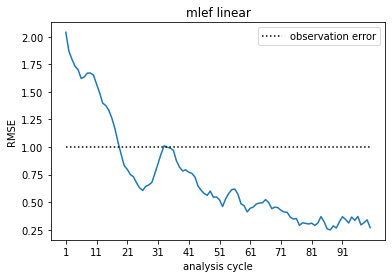

In [9]:
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()